In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from numba import njit, jit, prange
from img2vec import get_features
from distances import cosine_distance
import scipy.spatial.distance as metrics
import pickle
import random
from pathlib import Path

In [3]:
with open("data/buildings_features.pkl", "rb") as f:
    all_files = pickle.load(f)

print("Loaded %i feature vectors" % len(all_files))
for entry in all_files:
    entry["path"] = str(Path("../buildings") / f"{entry['filename']}.jpg")
    for key in entry["features"]:
        entry["features"][key] = entry["features"][key] / np.linalg.norm(
            entry["features"][key])

test_files = glob("../buildings/test/*.jpg")
random.shuffle(test_files)

print(f"Testing {len(test_files)} images")

Loaded 540 feature vectors
Testing 360 images


In [5]:
from img2vec import get_features
y_true = []
y_pred = []

for file_path in test_files:
    building = file_path.split("/")[-1].split("_")[0]
    y_true.append(building)

    query = cv2.imread(file_path)
    query_f = get_features(query)
    query_features = np.concatenate([(query_f[key]) / np.linalg.norm(query_f[key]) for key in query_f])

    distances = []
    for db_img in all_files:
        df = np.concatenate([
            db_img["features"][key] for key in db_img["features"]
        ])
        distances.append({
          "name": db_img["filename"],
          "building": db_img["filename"].split("_")[0],
          "distance": metrics.braycurtis(query_features, df)
      })
    
    distances = sorted(distances, key=lambda x: x['distance'], reverse=False)
    top3 = distances[1:4]
    predicted_building = max(top3, key=lambda x: top3.count(x))['building']
    y_pred.append(predicted_building)

    if building == predicted_building:
        print(f"Correctly predicted {building}")
    else:
        print(f"Wrongly predicted {building} as {predicted_building}")

Wrongly predicted building14 as building03
Correctly predicted building11
Wrongly predicted building02 as building55
Wrongly predicted building38 as building60
Correctly predicted building46
Wrongly predicted building23 as building26
Wrongly predicted building58 as building28
Wrongly predicted building33 as building21
Wrongly predicted building60 as building08
Wrongly predicted building31 as building02
Correctly predicted building39
Correctly predicted building20
Wrongly predicted building18 as building24
Wrongly predicted building04 as building03
Correctly predicted building36
Correctly predicted building24
Correctly predicted building23
Correctly predicted building12
Wrongly predicted building55 as building44
Wrongly predicted building05 as building04
Wrongly predicted building48 as building50
Correctly predicted building32
Correctly predicted building41
Wrongly predicted building36 as building45
Correctly predicted building09
Wrongly predicted building26 as building55
Wrongly predic

<AxesSubplot: >

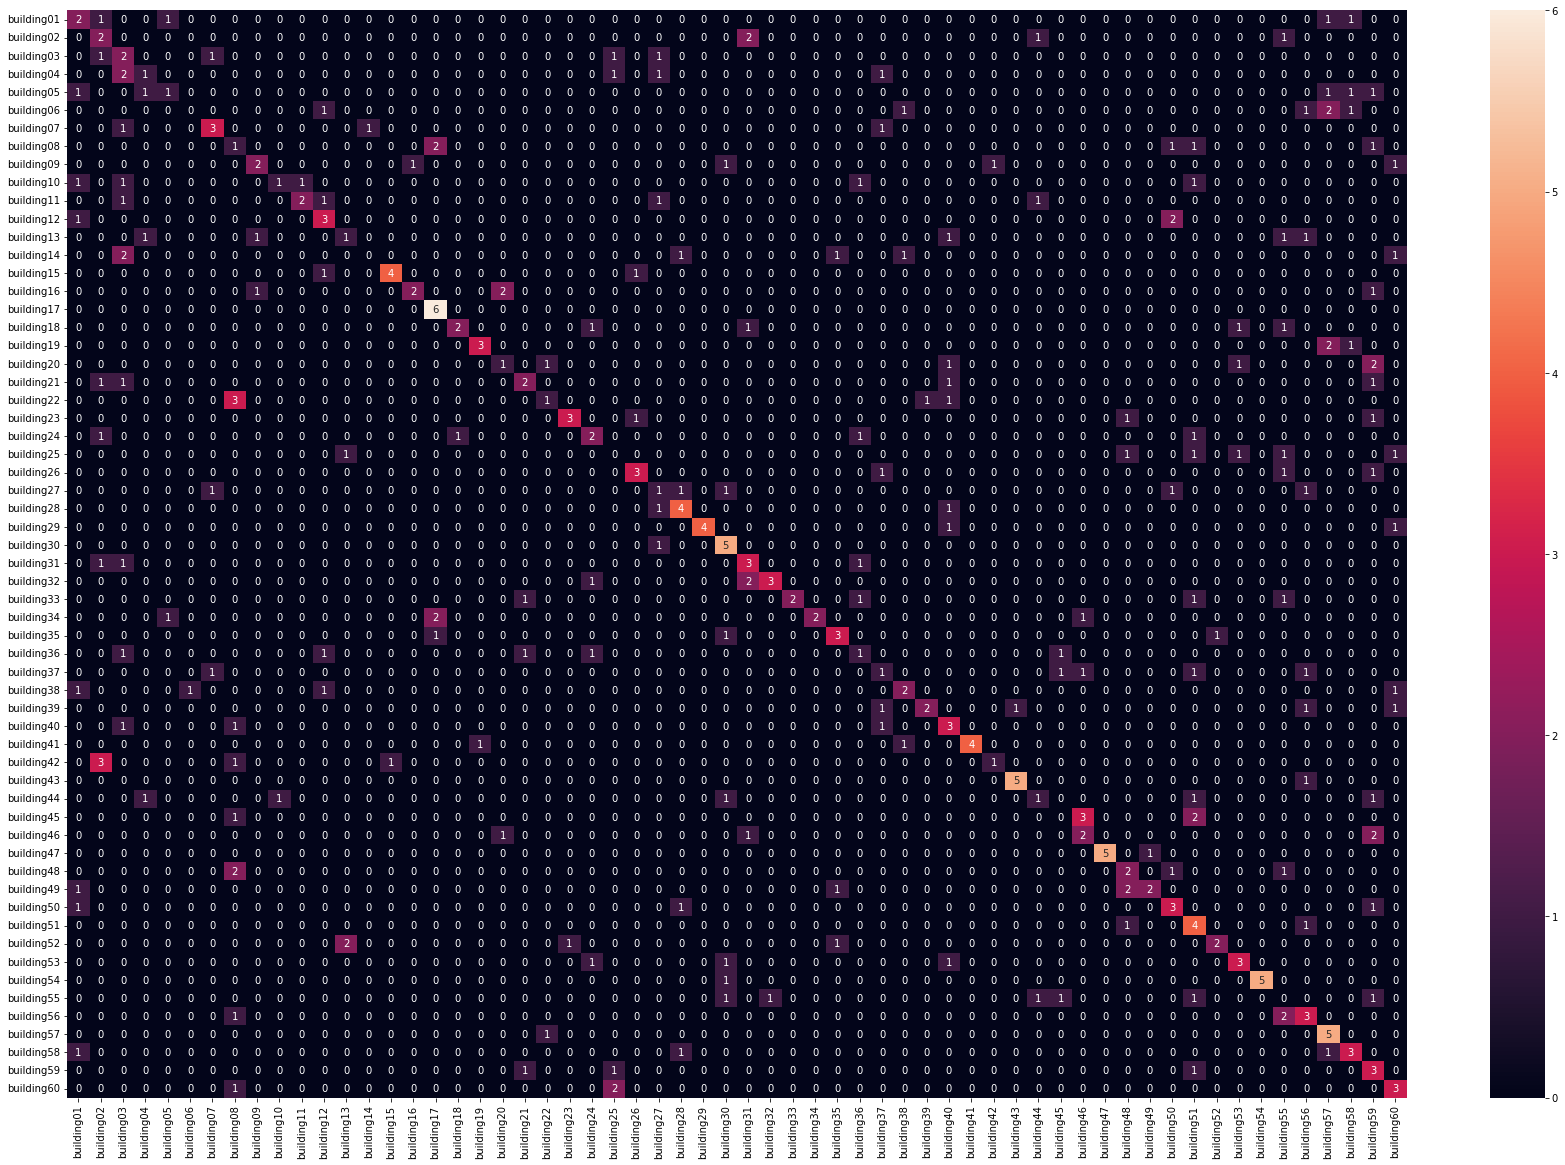

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y_true)],
                  columns = [i for i in np.unique(y_true)])
plt.figure(figsize = (30,20))
sn.heatmap(df_cm, annot=True)

In [7]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
print(accuracy_score(y_true, y_pred))
print(f1_score(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

0.39444444444444443
0.3930353129269539
              precision    recall  f1-score   support

  building01       0.22      0.33      0.27         6
  building02       0.20      0.33      0.25         6
  building03       0.15      0.33      0.21         6
  building04       0.25      0.17      0.20         6
  building05       0.33      0.17      0.22         6
  building06       0.00      0.00      0.00         6
  building07       0.50      0.50      0.50         6
  building08       0.09      0.17      0.12         6
  building09       0.50      0.33      0.40         6
  building10       0.50      0.17      0.25         6
  building11       0.67      0.33      0.44         6
  building12       0.38      0.50      0.43         6
  building13       0.25      0.17      0.20         6
  building14       0.00      0.00      0.00         6
  building15       0.80      0.67      0.73         6
  building16       0.67      0.33      0.44         6
  building17       0.55      1.00      0.7

In [7]:
classes = ["coast", "desert", "forest", "mountain", "glacier"]

In [9]:
y_true = []
y_pred = []

for entry in all_test_files:
  query = cv2.imread(entry)
  query_f = get_features(query)
  query_features = np.concatenate([(query_f[key]) / np.linalg.norm(query_f[key]) for key in query_f])

  distances = []
  for db_img in all_files:
      df = np.concatenate([
          db_img["features"][key] for key in db_img["features"]
      ])
      distances.append({
          "name": db_img["filename"],
          "class":  classes.index(db_img["class"]),
          "distance": cosine_distance(query_features, df)
      })
  distances = sorted(distances, key=lambda x: x["distance"], reverse=False)
  selfClass = Path(entry).parent.name.lower()
  selfClass = classes.index(selfClass)
  # predict class from top 5 results
  top10 = [x["class"] for x in distances[:5]]
  if len(top10) == 0:
    continue
  predictedClass = max(set(top10), key=top10.count)
  if predictedClass == selfClass:
    print(f"PASS {Path(entry).name} - {classes[predictedClass]} - {top10.count(predictedClass)/len(top10)}")
  else:
    print(f"FAIL {Path(entry).name} - {classes[predictedClass]} - {top10.count(predictedClass)/len(top10)}")
  y_true.append(selfClass)
  y_pred.append(predictedClass)

FAIL Desert-Test (44).jpeg - coast - 0.6
PASS Coast-Test (126).jpeg - coast - 0.4
PASS Coast-Test (114).jpeg - coast - 1.0
FAIL Forest-Test (23).jpeg - mountain - 0.6
PASS Coast-Test (170).jpeg - coast - 0.6
PASS Coast-Test (157).jpeg - coast - 0.6
PASS Glacier (399).jpeg - glacier - 1.0
PASS Coast-Test (93).jpeg - coast - 1.0
PASS Coast-Test (91).jpeg - coast - 0.6
PASS Coast-Test (181).jpeg - coast - 0.8
FAIL Mountain-Test (32).jpeg - glacier - 1.0
FAIL Forest-Test (4).jpeg - mountain - 0.8
PASS Desert-Test (94).jpeg - desert - 1.0
PASS Glacier (307).jpeg - glacier - 0.8
PASS Desert-Test (76).jpeg - desert - 0.8
PASS Glacier (364).jpeg - glacier - 1.0
PASS Coast-Test (118).jpeg - coast - 1.0
PASS Desert-Test (29).jpeg - desert - 0.8
PASS Coast-Test (171).jpeg - coast - 0.4
PASS Forest-Test (62).jpeg - forest - 1.0
PASS Forest-Test (95).jpeg - forest - 1.0
PASS Glacier (356).jpeg - glacier - 1.0
PASS Coast-Test (119).jpeg - coast - 0.8
FAIL Forest-Test (54).jpeg - coast - 0.6
PASS Des

In [10]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [12]:
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro')}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro')}")
print(f"F1: {f1_score(y_true, y_pred, average='macro')}")

Accuracy: 0.718
Precision: 0.7269867565630275
Recall: 0.718
F1: 0.7101406024893139


<AxesSubplot: >

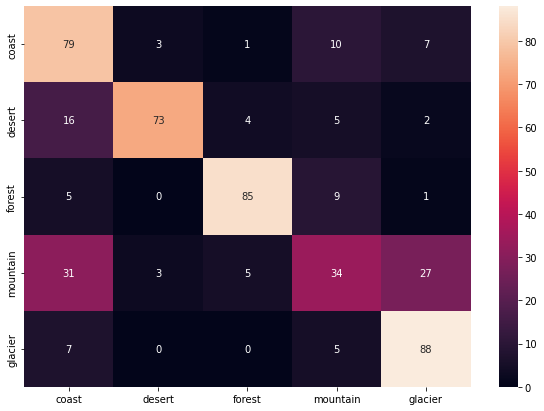

In [11]:
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt="d")